# Arch Data Pose Annotations

In this notebook, we show how to load data from the **Arch-Dataset** and how to overlay the keypoint annotations for pose estimation.

In [1]:
import os
import sys
import json

import numpy as np
import cv2
import torch
from matplotlib import pyplot as plt
from torch.nn import DataParallel
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

sys.path.append("..")

from data.ArchDataset import ArchDataset
from lib.bounding_box import bbox_filtering
from lib.detection_coco_utils import get_coco_api_from_dataset
from lib.detection_coco_eval import CocoEvaluator
from lib.loss import PersonMSELoss
from lib.metrics import generate_submission_hrnet, compute_precision
from lib.model_setup import load_model, load_checkpoint
from lib.pose_parsing import get_final_preds_hrnet, create_pose_entries
from lib.utils import load_experiment_parameters, reset_predictions_file
from lib.visualizations import visualize_image, overlay_heatmap, draw_pose

from CONFIG import CONFIG
import CONSTANTS
import lib.pose_parsing as pose_parsing
import data.data_processing as data_processing

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
pose_parsing.SKELETON = CONSTANTS.SKELETON_SIMPLE
data_processing.TO_COCO_MAP = CONSTANTS.COCO_MAP_HRNET
data_processing.SKIP_NECK = False
loss_function = PersonMSELoss()

In [4]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(
    mean=mean.tolist(), std=std.tolist()
)

In [5]:
exp_name = os.path.join("hrnet_tests", "styled_coco_augmented_epochs_150_lr_1e-3")
# exp_name = os.path.join("hrnet_tests", "coco_exp")
exp_path = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)
checkpoint_path = os.path.join(exp_path, "models", "checkpoint_epoch_100.pth")

exp_data = load_experiment_parameters(exp_path)
exp_data["dataset"]["dataset_name"] = "arch_data"
labels_path = os.path.join(CONFIG["paths"]["data_path"], "annotations_arch_data")
labels_file = os.path.join(labels_path, "arch_data_keypoints.json")
preds_file = os.path.join(exp_path, CONFIG["paths"]["submission"])

# Loading and Inspecting Dataset

In [6]:
arch_dataset = ArchDataset(task="pose_estimation",
                           split_set="train",
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               normalize,
                            ]))
print(f"Arch-Dataset containing {len(arch_dataset)} images.")
print(f"Arch-Dataset containing {arch_dataset.num_instances} instances.")

creating index...
index created!
Arch-Dataset containing 20 images.
Arch-Dataset containing 20 instances.


In [7]:
idx = 0
# idx = np.random.randint(low=0, high=len(arch_dataset))

img, target, target_weight, meta = arch_dataset[idx]
print(f"Loaded image: {meta['image']}")
# print(f"Keypoints: {meta['joints']}")

Loaded image: abductor_3832_e0063.jpg


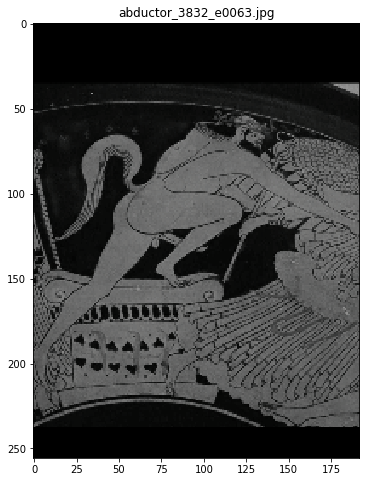

In [8]:
visualize_image(img=img, preprocess=True, title=meta["image"])

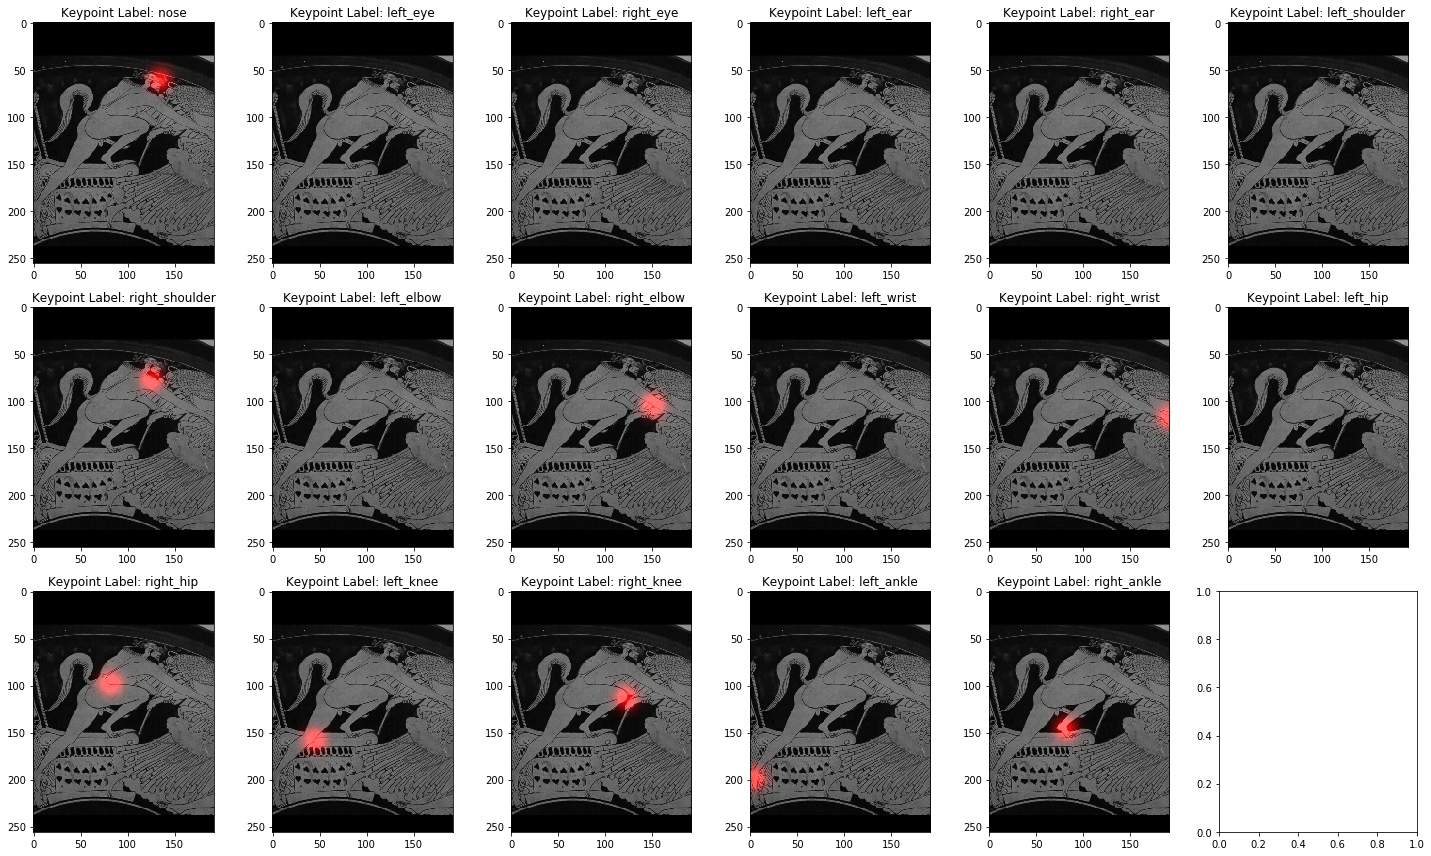

In [9]:
scaled_target = F.interpolate(target[np.newaxis,:].clone().detach(), (256, 192),
                              mode="bilinear", align_corners=True)[0,:]

fig, ax = plt.subplots(3,6)
fig.set_size_inches(20,12)

for i in range(17):
    row = i // 6
    col = i% 6
    title = f"Keypoint Label: {CONSTANTS.IDX_TO_KPT_NAME[i]}"
    overlay_heatmap(heatmap=np.array(scaled_target[i,:]), img=np.array(img),
                    ax=ax[row, col], title=title)
plt.tight_layout()
plt.show()

In [10]:
# pose parsing
centers = meta["center"]
scales = meta["scale"]
print(scales)
score = meta["score"]

keypoints, max_vals, coords = get_final_preds_hrnet(target[np.newaxis,:].numpy(), [centers], [scales])
pose_entries, all_keypoints = create_pose_entries(keypoints)

all_keypoints = [all_keypoints[:, 1], all_keypoints[:, 0], all_keypoints[:, 2], all_keypoints[:, 3]]
all_keypoints = np.array(all_keypoints).T

[5.25520833 5.25520833]


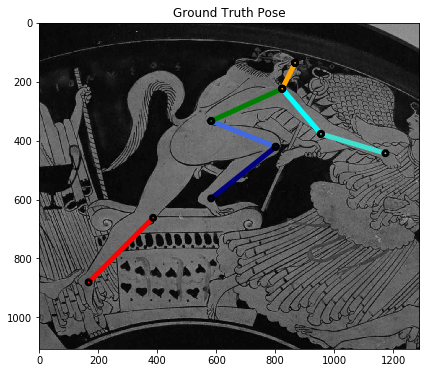

In [11]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

title = "Ground Truth Pose"
full_img = cv2.imread(meta["image_path"], cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)
_ = draw_pose(full_img, pose_entries, all_keypoints, ax=ax, title=title)

# Testing a Model

### Loading Dataloader and Pretrained Model


In [12]:
data_loader = DataLoader(arch_dataset, batch_size=1, shuffle=False, num_workers=1)

In [113]:
tuned_model = load_model(exp_data=exp_data, checkpoint=True)
tuned_model = DataParallel(tuned_model).eval()
tuned_model = load_checkpoint(checkpoint_path, model=tuned_model, only_model=True)

In [114]:
raw_model = load_model(exp_data=exp_data)
raw_model = DataParallel(raw_model).eval()

Loading COCO pretrained weights...


### Evaluation with HRNet tuned on Styled-COCO

In [115]:
it = iter(data_loader)
for i in range(4):
    imgs, target, target_weight, meta = next(it)
imgs = imgs.float()
target = target.float()
raw_output = raw_model(imgs).cpu().detach()
tuned_output = tuned_model(imgs).cpu().detach()

In [118]:
scaled_output = F.interpolate(tuned_output, (256, 192),
                              mode="bilinear", align_corners=True)
n_images = tuned_output.shape[0]
n_joints = tuned_output.shape[1]

In [119]:
raw_loss_value = loss_function(raw_output.cpu(), target, target_weight).item()
print(f"Loss Value Raw Model: {round(raw_loss_value,5)}")
tuned_loss_value = loss_function(tuned_output.cpu(), target, target_weight).item()
print(f"Loss Value Tuned Model: {round(tuned_loss_value,5)}")

Loss Value Raw Model: 0.00557
Loss Value Tuned Model: 0.00548


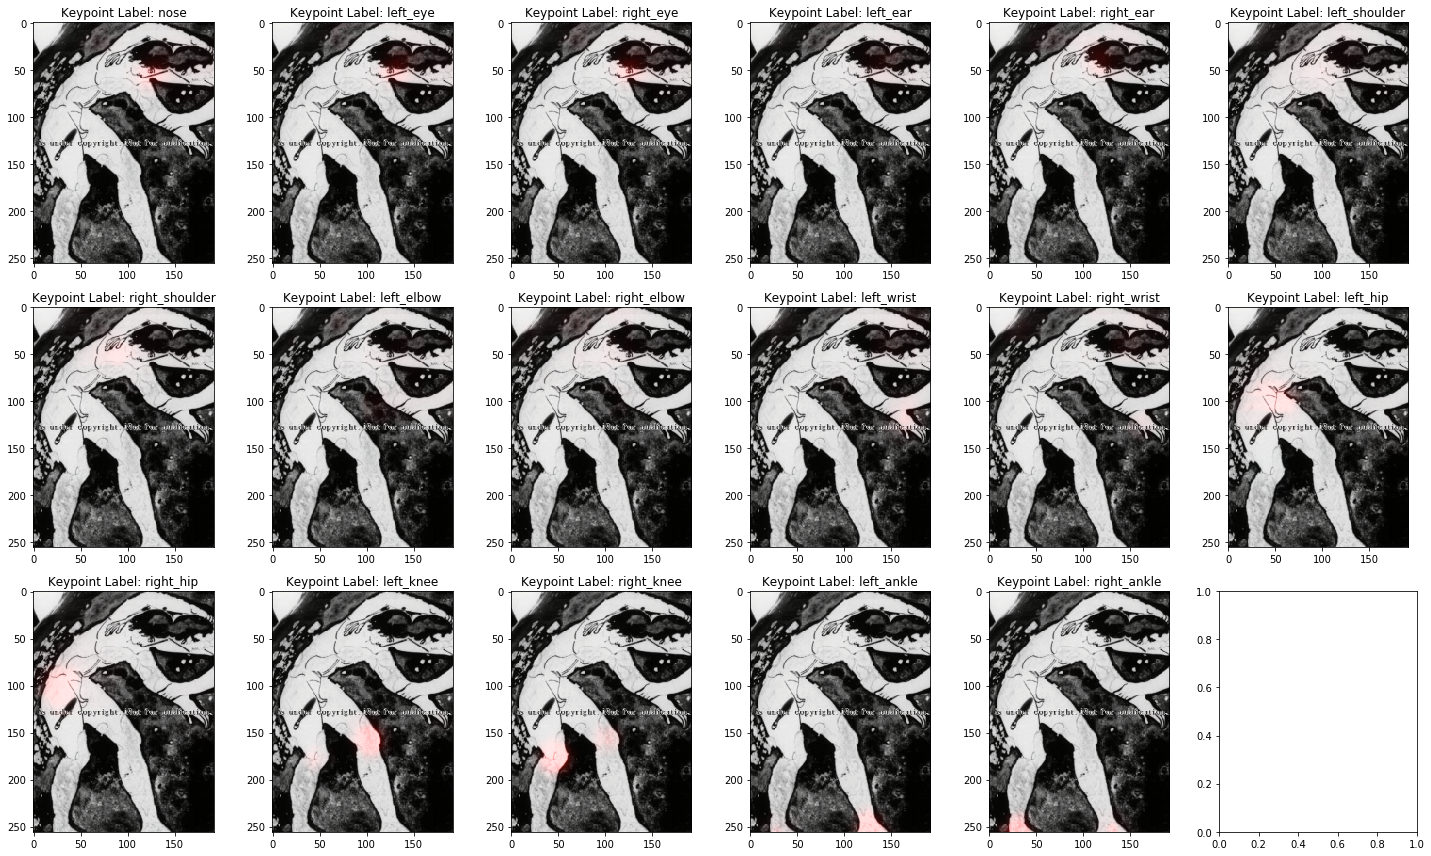

In [120]:
fig, ax = plt.subplots(3,6)
fig.set_size_inches(20,12)

for i in range(n_joints):
    row = i // 6
    col = i% 6
    title = f"Keypoint Label: {CONSTANTS.IDX_TO_KPT_NAME[i]}"
    overlay_heatmap(heatmap=np.array(scaled_output[0,i,:].cpu()), img=np.array(imgs[0,:].cpu()),
                    ax=ax[row, col], title=title)
plt.tight_layout()
plt.show()

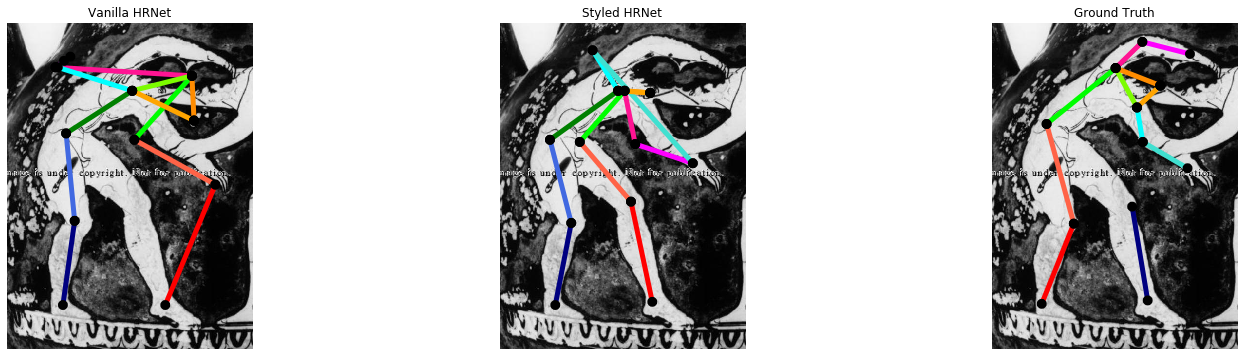

In [132]:
# pose parsing
centers = meta["center"].numpy()
scales = meta["scale"].numpy()
score = meta["score"].numpy()

raw_keypoints, raw_max_vals, coords = get_final_preds_hrnet(raw_output.cpu().detach().numpy(), centers, scales)
raw_pose_entries, raw_all_keypoints = create_pose_entries(raw_keypoints)
raw_all_keypoints = [raw_all_keypoints[:, 1], raw_all_keypoints[:, 0], raw_all_keypoints[:, 2], raw_all_keypoints[:, 3]]
raw_all_keypoints = np.array(raw_all_keypoints).T

tuned_keypoints, tuned_max_vals, coords = get_final_preds_hrnet(tuned_output.cpu().detach().numpy(), centers, scales)
tuned_pose_entries, tuned_all_keypoints = create_pose_entries(tuned_keypoints)
tuned_all_keypoints = [tuned_all_keypoints[:, 1], tuned_all_keypoints[:, 0], tuned_all_keypoints[:, 2], tuned_all_keypoints[:, 3]]
tuned_all_keypoints = np.array(tuned_all_keypoints).T

fig, ax = plt.subplots(1,3)
fig.set_size_inches(25,6)

title = "Vanilla HRNet"
full_img = cv2.imread(meta["image_path"][0], cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)
draw_pose(full_img, raw_pose_entries, raw_all_keypoints, ax=ax[0], title=title, axis_off=True)

title = "Styled HRNet"
full_img = cv2.imread(meta["image_path"][0], cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)
draw_pose(full_img, tuned_pose_entries, tuned_all_keypoints, ax=ax[1], title=title, axis_off=True)

title = "Ground Truth"
full_img = cv2.imread(meta["image_path"][0], cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)
or_joints = meta["original_joints"].numpy()
or_joints = [or_joints[0,:,1], or_joints[0,:,0], or_joints[0,:,2], or_joints[0,:,2]]
or_joints = np.array(or_joints).T
draw_pose(full_img, pose_entries, or_joints, ax=ax[2], title=title, axis_off=True)

savename = meta["image_path"][0].split("/")[-1]
savepath = os.path.join(os.getcwd(), "imgs", "archdata_poses", savename)
plt.savefig(savepath)

<Figure size 432x288 with 0 Axes>

### COCO Evaluation Metrics

In [125]:
all_preds = np.zeros((1, 17, 3), dtype=np.float32)
all_preds[:,:,:2] = tuned_keypoints[:,:,:2]
all_preds[:,:,2:3] = tuned_max_vals

In [126]:
all_boxes = np.zeros((1, 6))
all_boxes[:, 0:2] = centers[:, 0:2]
all_boxes[:, 2:4] = scales[:, 0:2]
all_boxes[:, 4] = np.prod(scales*200, 1)
all_boxes[:, 5] = score

In [127]:
reset_predictions_file(exp_path)
generate_submission_hrnet(all_preds=[all_preds], all_bboxes=[all_boxes], 
                          image_names=[meta["image_id"].item()], preds_file=preds_file, name=False)
# generate_submission_hrnet(all_preds=[aux], all_bboxes=[all_boxes], 
#                           image_names=[meta["image_id"].item()], preds_file=preds_file, name=False)

In [128]:
stats = compute_precision(labels_file=labels_file, preds_file=preds_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | m


<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 